In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os
from create_analyze_runs_helpers import *

### Experiment settings

In [2]:
def small_setting():
    # SMALL setting experiments
    setting_name = 'small'
    common = {'image_side': 4, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 1, 'architecture': '20_10'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 1.0, 'epochs': 100, **common}],

        'frankwolfe':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'p': 2.0, 'R': 100.0, 'gamma': -1.0, 'ro': -1.0,
         'epochs': 100, **common}],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'p': 2.0, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 100, **common}],
    }
    return setting_name, common, param_groups

In [3]:
def medium_setting():
    # medium setting
    setting_name = 'medium_auto'
    common = {'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 100, **common}
         for lr in [0.1, 0.01, 0.001, 0.0001]],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
         'epochs': 100, **common} for gamma in [-1.] + [0.1, 0.5, 1.]
         for ro in [-1.] + list(np.linspace(0, 1, 3))],

        'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
         'epochs': 500, **common} for gamma in [-1.] + [0.1, 0.3, 0.5]],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 100, **common} for lr in [0.1, 0.01, 0.001, 0.0001]]
    }
    return setting_name, common, param_groups

In [4]:
def big_setting():
    # BIG setting
    setting_name = 'big'
    common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 1000, **common}
         for lr in [1., 0.5, 0.1, 0.05]],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
         'epochs': 1000, **common} for gamma in [-1.] + [0.1, 0.5]
         for ro in [-1.] + [0.1, 0.3, 0.5]],

        'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
         'epochs': 1000, **common, 'repetitions': 10} for gamma in [-1.]],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 1000, **common} for lr in [0.01, 0.001, 0.0001]]
    }
    return setting_name, common, param_groups

In [5]:
def batch_size_setting():
    # Medium 2 setting (batch size effect)
    setting_name = 'medium2'
    common = {'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
    batches = [1000, 5000, 10000, 60000]
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': bs, 'learning_rate': 1.0, 'epochs': 1000, **common}
         for bs in batches],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': bs, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0,
         'epochs': 1000, **common} for bs in batches],

        'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': -1.0, 'ro': 1.0,
         'epochs': 5000, **common}],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': bs, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 1000, **common} for bs in batches]
    }
    return setting_name, common, param_groups

### Choosing a setting

In [6]:
#R = small_setting()
#R = medium_setting()
R = big_setting()
#R = batch_size_setting()

In [7]:
# name of the setting, common parameters, parameter groups, all parameters
setting_name, common, param_groups = R
parameters = [x for group in param_groups.values() for x in group]

In [8]:
# group -> what changes
varying = {group: varying_for_optim(param_groups[group]) for group in param_groups.keys()}

print(varying)

{'sgd': ['learning_rate'], 'frankwolfe_stochastic': ['gamma', 'ro'], 'frankwolfe_deterministic': [], 'adam': ['learning_rate']}


### Creating the `.sh` file

In [9]:
# writing the .sh file
write_sh_file(setting_name, parameters, common)

OUTPUT: ./output/run_big.sh
Total runs:  300
Total time (approx):  6.25


### Processing data

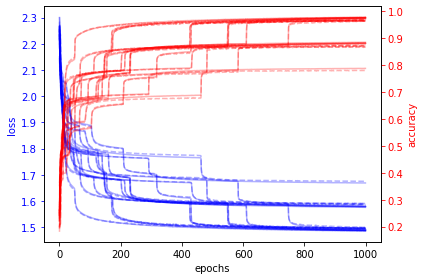

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.6691766, 1.4873391, 1.5803586, 1.4890198, 1.4884175, 1.4886366, 1.493281, 1.4861039, 1.4887214, 1.4916782, 1.4868821, 1.5798125, 1.5787891, 1.5762169, 1.5791763], 'test_loss': [1.6755672, 1.4969739, 1.5878774, 1.4974506, 1.4966966, 1.4950769, 1.5001593, 1.4940711, 1.496712, 1.4988748, 1.4967254, 1.590207, 1.5884037, 1.5856671, 1.5909721], 'train_acc': [0.78835, 0.9773167, 0.88055, 0.9754, 0.9763167, 0.9765667, 0.97211665, 0.9784167, 0.97618335, 0.97295, 0.9779, 0.88125, 0.88296664, 0.8854667, 0.8817833], 'test_acc': [0.7806, 0.9659, 0.8714, 0.9661, 0.9664, 0.9688, 0.9639, 0.969, 0.9657, 0.9646, 0.9658, 0.8689, 0.8722, 0.8751, 0.8678], 'p_norm': [26.472792, 29.764585, 27.942852, 28.817043, 29.283949, 29.810274, 28.854074, 30.071507, 28.900307, 29.166258, 29.440788, 27.97

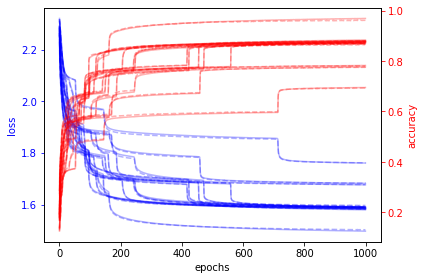

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.5, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.5883682, 1.4970937, 1.5843612, 1.5871025, 1.5831155, 1.5844467, 1.5795909, 1.5840516, 1.5900208, 1.6764606, 1.6824242, 1.5880495, 1.5835565, 1.5911492, 1.7606658], 'test_loss': [1.5921772, 1.5026115, 1.5887759, 1.5899947, 1.5878497, 1.5890394, 1.5822619, 1.5882546, 1.5967764, 1.6774246, 1.6827567, 1.5919151, 1.5895878, 1.5925908, 1.7614703], 'train_acc': [0.8755, 0.9689, 0.8789833, 0.8761333, 0.87995, 0.87795, 0.88355, 0.87848336, 0.87278336, 0.78255, 0.77595, 0.87383336, 0.879, 0.8700333, 0.69518334], 'test_acc': [0.8695, 0.9616, 0.8726, 0.8713, 0.8746, 0.8716, 0.8805, 0.8733, 0.8639, 0.7798, 0.7751, 0.868, 0.8711, 0.8678, 0.6931], 'p_norm': [25.184555, 26.634644, 24.823652, 25.575954, 25.376228, 25.511421, 25.884653, 26.061369, 25.758568, 24.275196, 24.256916, 25.8658

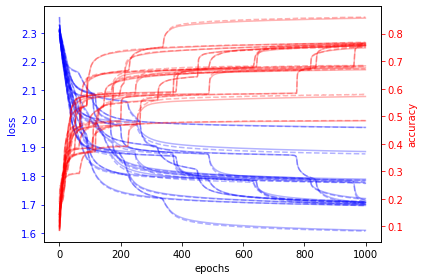

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.7017213, 1.7752013, 1.969975, 1.7092438, 1.7846612, 1.6972677, 1.8855948, 1.7144674, 1.7214217, 1.6105279, 1.7082179, 1.7068467, 1.7006795, 1.708275, 1.7890934], 'test_loss': [1.7026924, 1.7727721, 1.969531, 1.7042527, 1.7800074, 1.6981746, 1.8774629, 1.7085414, 1.7184743, 1.6076849, 1.7074112, 1.70288, 1.6963693, 1.711416, 1.7855008], 'train_acc': [0.76208335, 0.68296665, 0.48365, 0.75645, 0.67576665, 0.7668, 0.5717, 0.75841665, 0.7484, 0.8565, 0.75616664, 0.7607167, 0.76458335, 0.7564667, 0.6689], 'test_acc': [0.7598, 0.6847, 0.4843, 0.7615, 0.6801, 0.7651, 0.5791, 0.7635, 0.7516, 0.86, 0.7567, 0.7643, 0.7687, 0.7512, 0.6722], 'p_norm': [20.84824, 20.45911, 20.00805, 21.216406, 20.372673, 21.47938, 20.412434, 20.712473, 21.496294, 21.793804, 20.752563, 20.705894, 20.8

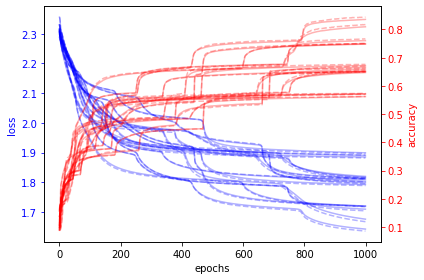

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.05, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.8172232, 1.8096721, 1.7201406, 1.7992439, 1.7206818, 1.8995284, 1.8202184, 1.8853892, 1.8036509, 1.6763369, 1.642966, 1.890851, 1.7099286, 1.7927346, 1.8138648], 'test_loss': [1.8151718, 1.8119438, 1.7180816, 1.8020746, 1.7192805, 1.8971055, 1.8113115, 1.8823164, 1.7955989, 1.667814, 1.6361873, 1.8918254, 1.7043715, 1.7892953, 1.8127387], 'train_acc': [0.64996666, 0.65255, 0.7495667, 0.66618335, 0.74801666, 0.56236666, 0.64746666, 0.57195, 0.6601, 0.80951667, 0.83578336, 0.5715167, 0.7603667, 0.6723833, 0.65195], 'test_acc': [0.6515, 0.649, 0.7506, 0.6632, 0.75, 0.5626, 0.6575, 0.5738, 0.67, 0.8173, 0.8439, 0.5701, 0.7669, 0.6764, 0.6519], 'p_norm': [19.747988, 20.138987, 20.337921, 20.023258, 20.331573, 19.65147, 20.06961, 19.57663, 20.088993, 20.581186, 20.409895, 19

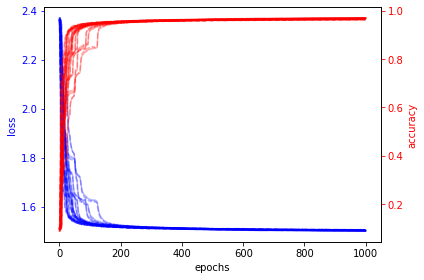

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.5027674, 1.504571, 1.5016997, 1.5016943, 1.501619, 1.5045148, 1.5018448, 1.5017258, 1.5002042, 1.5016148, 1.5017294, 1.5006205, 1.501477, 1.502923, 1.5020528], 'test_loss': [1.5043863, 1.5068955, 1.5035383, 1.5038962, 1.5042655, 1.5055172, 1.5034605, 1.5032082, 1.5019633, 1.5042121, 1.5033944, 1.5025151, 1.5045567, 1.5035005, 1.5045432], 'train_acc': [0.96758336, 0.9666, 0.96886665, 0.96886665, 0.9696, 0.9663333, 0.9684333, 0.9683833, 0.9706, 0.9691, 0.9684167, 0.96991664, 0.96893334, 0.9676167, 0.96903336], 'test_acc': [0.9637, 0.9605, 0.9642, 0.9654, 0.9647, 0.9632, 0.9646, 0.9639, 0.9666, 0.9644, 0.9644, 0.9661, 0.9642, 0.9649, 0.9634], 'p_norm': [16.084469, 15.733581, 15.939426, 16.069588, 15.971254, 15.663785, 16.050781, 16.177006, 16.030722,

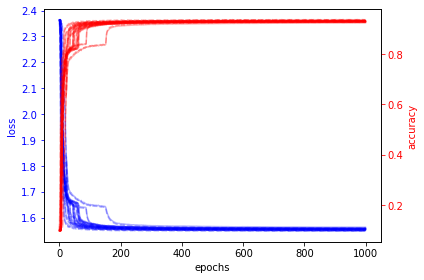

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': 0.1, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.5554022, 1.5542412, 1.5581065, 1.5627367, 1.555151, 1.5588539, 1.5574095, 1.557998, 1.5523868, 1.553351, 1.5574455, 1.55467, 1.5518374, 1.5584339, 1.5547911], 'test_loss': [1.5516036, 1.5497149, 1.5545474, 1.5589303, 1.5511668, 1.5550852, 1.5532833, 1.5532967, 1.5478734, 1.549473, 1.5531237, 1.5506591, 1.547502, 1.5537473, 1.5511435], 'train_acc': [0.9288167, 0.93023336, 0.92613333, 0.92325, 0.9291667, 0.92586666, 0.9281833, 0.9277667, 0.9317167, 0.92943335, 0.92798334, 0.9288833, 0.93186665, 0.92795, 0.92966664], 'test_acc': [0.9311, 0.9347, 0.9284, 0.9263, 0.9317, 0.9282, 0.9309, 0.9317, 0.9336, 0.9341, 0.9308, 0.933, 0.9356, 0.9316, 0.9331], 'p_norm': [11.900108, 12.005138, 11.73607, 11.699444, 11.921743, 11.79155, 11.901136, 11.912744, 12.03510

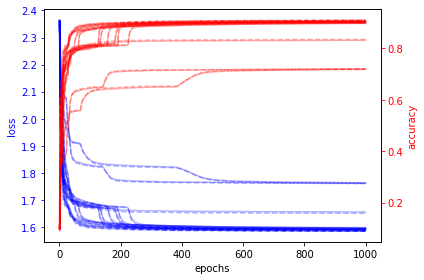

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': 0.3, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.5918204, 1.5982953, 1.5926539, 1.5969934, 1.7621464, 1.5923023, 1.5964104, 1.5941892, 1.5910152, 1.5955942, 1.591175, 1.6561774, 1.5910608, 1.7639505, 1.5916858], 'test_loss': [1.5855438, 1.5922809, 1.5868533, 1.5917121, 1.7608535, 1.5869111, 1.5907627, 1.5878068, 1.5860395, 1.5898093, 1.5856702, 1.6510693, 1.5853658, 1.7618028, 1.5865271], 'train_acc': [0.90348333, 0.89858335, 0.90243334, 0.8969667, 0.7194167, 0.90225, 0.89775, 0.8993, 0.9029, 0.90043336, 0.90281665, 0.83136666, 0.9027167, 0.71821666, 0.9034333], 'test_acc': [0.9097, 0.9031, 0.9061, 0.9006, 0.7207, 0.9068, 0.9035, 0.9056, 0.9082, 0.9049, 0.9076, 0.8347, 0.9083, 0.7207, 0.9068], 'p_norm': [10.676151, 10.628294, 10.620824, 10.478637, 9.556461, 10.52057, 10.495655, 10.557296, 10.5425

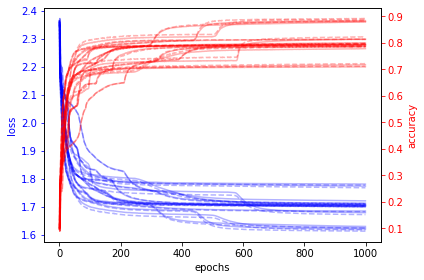

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': 0.5, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.7202451, 1.678045, 1.7046953, 1.6196475, 1.7029854, 1.6240094, 1.7076408, 1.7067696, 1.6999018, 1.7022599, 1.7727842, 1.7801523, 1.6839452, 1.6288136, 1.7118757], 'test_loss': [1.7106601, 1.6712264, 1.7019808, 1.612036, 1.6986027, 1.6165882, 1.707267, 1.703732, 1.6990209, 1.7000375, 1.7670602, 1.7763761, 1.6816959, 1.6228162, 1.7098805], 'train_acc': [0.77748334, 0.81313336, 0.79045, 0.88318336, 0.79305, 0.87965, 0.78793335, 0.79285, 0.7991, 0.79355, 0.71641666, 0.70881665, 0.81235, 0.8785167, 0.78466666], 'test_acc': [0.7863, 0.8221, 0.7886, 0.8908, 0.7952, 0.8879, 0.787, 0.7963, 0.7981, 0.7934, 0.7211, 0.7105, 0.8128, 0.8839, 0.784], 'p_norm': [9.6090555, 9.527867, 9.321676, 9.963961, 9.724253, 9.793484, 9.226775, 9.580413, 9.680218, 9.435366, 9.

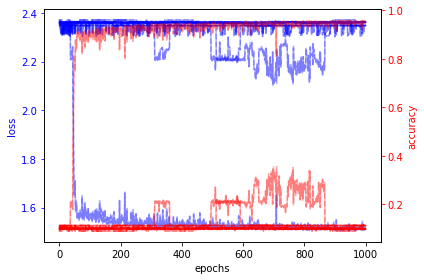

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': -1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [2.36185, 1.5143028, 2.3636334, 2.3487833, 2.3487833, 2.3624334, 2.3637834, 2.3625166, 2.362, 2.3625166, 2.3487833, 2.3487833, 2.3624334, 2.3637834, 2.3487833], 'test_loss': [2.3579502, 1.5127822, 2.3637502, 2.3476503, 2.3476503, 2.3631501, 2.36295, 2.3653502, 2.3602502, 2.3653502, 2.3476503, 2.3476503, 2.3631501, 2.36295, 2.3476503], 'train_acc': [0.0993, 0.9500167, 0.09751666, 0.11236667, 0.11236667, 0.09871667, 0.09736667, 0.098633334, 0.09915, 0.098633334, 0.11236667, 0.11236667, 0.09871667, 0.09736667, 0.11236667], 'test_acc': [0.1032, 0.9506, 0.0974, 0.1135, 0.1135, 0.098, 0.0982, 0.0958, 0.1009, 0.0958, 0.1135, 0.1135, 0.098, 0.0982, 0.1135], 'p_norm': [17.772387, 19.888357, 19.73519, 19.971548, 19.489664, 19.72963, 19.246502, 19.67415, 19.7996

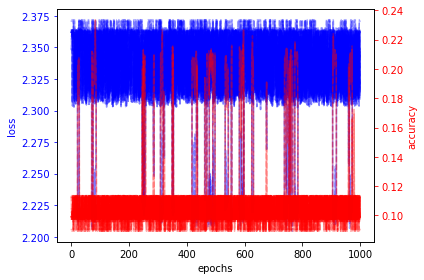

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': 0.1, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [2.3197718, 2.3487823, 2.3141575, 2.3422256, 2.36185, 2.3624334, 2.362, 2.3708, 2.3487833, 2.312243, 2.3090246, 2.3636334, 2.3624334, 2.3625166, 2.318964], 'test_loss': [2.3200922, 2.3476489, 2.3140545, 2.3412263, 2.3579502, 2.3631501, 2.3602502, 2.3719501, 2.3476503, 2.3119853, 2.3096118, 2.3637502, 2.3631501, 2.3653502, 2.3166673], 'train_acc': [0.11236667, 0.11236667, 0.098633334, 0.11236667, 0.0993, 0.09871667, 0.09915, 0.09035, 0.11236667, 0.09871667, 0.10441667, 0.09751666, 0.09871667, 0.098633334, 0.09915], 'test_acc': [0.1135, 0.1135, 0.0958, 0.1135, 0.1032, 0.098, 0.1009, 0.0892, 0.1135, 0.098, 0.1028, 0.0974, 0.098, 0.0958, 0.1009], 'p_norm': [12.969025, 19.02232, 11.562631, 9.901571, 4.9682155, 13.397225, 19.904997, 5.368028, 15.000585, 12.7

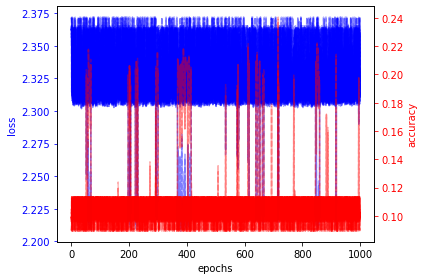

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': 0.3, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [2.3708, 2.308053, 2.311298, 2.362, 2.3226032, 2.310776, 2.3298213, 2.3708, 2.3589666, 2.3104553, 2.324626, 2.3160305, 2.3275511, 2.3589666, 2.3076172], 'test_loss': [2.3719501, 2.3074806, 2.3117769, 2.3602502, 2.3233087, 2.3096693, 2.331961, 2.3719501, 2.36015, 2.3101418, 2.3254652, 2.315468, 2.3287735, 2.36015, 2.3080173], 'train_acc': [0.09035, 0.09736667, 0.10441667, 0.09915, 0.102183335, 0.09915, 0.098633334, 0.09035, 0.102183335, 0.09915, 0.10441667, 0.09915, 0.102183335, 0.102183335, 0.102183335], 'test_acc': [0.0892, 0.0982, 0.1028, 0.1009, 0.101, 0.1009, 0.0958, 0.0892, 0.101, 0.1009, 0.1028, 0.1009, 0.101, 0.101, 0.101], 'p_norm': [19.154263, 4.981767, 5.1450086, 18.731394, 6.319661, 7.377207, 6.2391043, 16.929081, 16.31287, 7.6684375, 4.8681

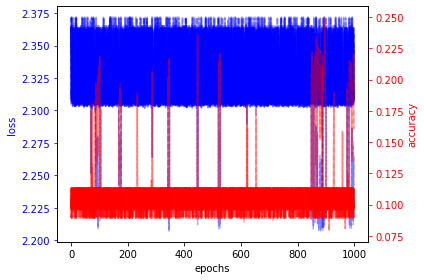

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': 0.5, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [2.3636334, 2.3068354, 2.362, 2.3136115, 2.312496, 2.3179417, 2.3080359, 2.3143082, 2.2640498, 2.3126423, 2.3052142, 2.30897, 2.3092592, 2.3487833, 2.3512266], 'test_loss': [2.3637502, 2.3072338, 2.3602502, 2.3140364, 2.3136687, 2.31872, 2.3081977, 2.3139718, 2.264893, 2.3124883, 2.3056433, 2.3091934, 2.3080652, 2.3476503, 2.351797], 'train_acc': [0.09751666, 0.09736667, 0.09915, 0.09751666, 0.098633334, 0.09871667, 0.09751666, 0.11236667, 0.16138333, 0.11236667, 0.09035, 0.09035, 0.09915, 0.11236667, 0.09871667], 'test_acc': [0.0974, 0.0982, 0.1009, 0.0974, 0.0958, 0.098, 0.0974, 0.1135, 0.1603, 0.1135, 0.0892, 0.0892, 0.1009, 0.1135, 0.098], 'p_norm': [15.572496, 5.118853, 14.977198, 5.918533, 4.7280626, 5.591277, 5.2449436, 5.59744, 9.724012, 5.2465

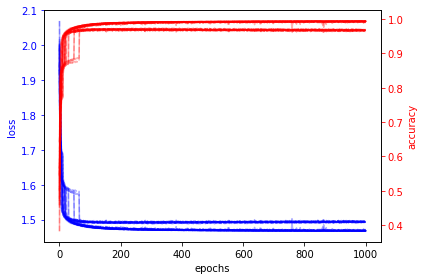

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.01, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.4686128, 1.4670599, 1.4675345, 1.4671708, 1.4688762, 1.4675764, 1.4687409, 1.468324, 1.4685899, 1.4677807, 1.4680289, 1.4691768, 1.4689882, 1.4671198, 1.4670904], 'test_loss': [1.4951802, 1.4914281, 1.4938546, 1.4935964, 1.4939972, 1.4931666, 1.4940381, 1.4935083, 1.4941013, 1.4916818, 1.4939783, 1.4969689, 1.4940324, 1.4931142, 1.4930428], 'train_acc': [0.99266666, 0.99411666, 0.99373335, 0.99396664, 0.9923, 0.99363333, 0.9925167, 0.9928833, 0.99265, 0.99345, 0.99326664, 0.9921, 0.99226665, 0.99408334, 0.99405], 'test_acc': [0.9661, 0.9696, 0.967, 0.9674, 0.9667, 0.9679, 0.9669, 0.9674, 0.9665, 0.9689, 0.967, 0.9638, 0.9673, 0.968, 0.968], 'p_norm': [100.131355, 101.948326, 102.19036, 101.81737, 108.82584, 102.92098, 10

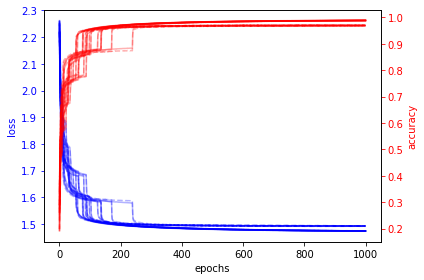

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.4727589, 1.4733589, 1.4733182, 1.4738685, 1.472995, 1.473894, 1.4736375, 1.4726393, 1.4739105, 1.4733396, 1.4740416, 1.473737, 1.4739105, 1.4735497, 1.4735618], 'test_loss': [1.491608, 1.492756, 1.491648, 1.4921224, 1.4917164, 1.4927851, 1.4935235, 1.490823, 1.4911497, 1.4920598, 1.4929594, 1.4918604, 1.4929156, 1.4923222, 1.4923451], 'train_acc': [0.9889, 0.98836666, 0.98838335, 0.98795, 0.98871666, 0.9879, 0.98835, 0.98903334, 0.9879, 0.9884, 0.98775, 0.98808336, 0.9877, 0.98833334, 0.9881333], 'test_acc': [0.9698, 0.9683, 0.9703, 0.9688, 0.9697, 0.9687, 0.9685, 0.9709, 0.9703, 0.9692, 0.9684, 0.9694, 0.9683, 0.9692, 0.969], 'p_norm': [47.363472, 46.1058, 46.352943, 45.868683, 46.057583, 45.24392, 45.909023, 45.978233

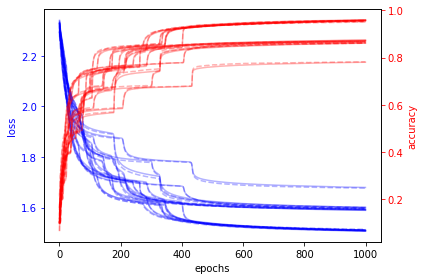

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.0001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': [1.50882, 1.5089265, 1.5949187, 1.5920297, 1.5108211, 1.6795198, 1.6005678, 1.5901326, 1.5063443, 1.5076171, 1.6005495, 1.5081227, 1.5890055, 1.5909408, 1.5098951], 'test_loss': [1.5111271, 1.5111406, 1.5981609, 1.595242, 1.5140535, 1.676768, 1.5990343, 1.5937961, 1.5089974, 1.508615, 1.6000508, 1.5114601, 1.5936223, 1.5935844, 1.5104735], 'train_acc': [0.9579, 0.9579333, 0.86855, 0.87161666, 0.95665, 0.7807, 0.8626, 0.8735667, 0.9601667, 0.95888335, 0.86151665, 0.95923334, 0.8749667, 0.87186664, 0.95715], 'test_acc': [0.9562, 0.953, 0.8639, 0.8672, 0.9513, 0.7825, 0.8618, 0.8688, 0.9576, 0.9569, 0.8615, 0.9535, 0.8689, 0.868, 0.9557], 'p_norm': [24.832325, 24.878878, 24.365301, 24.157007, 25.011042, 23.657503, 24.388498,

In [10]:
# parameter id -> processed file
params_to_processed = []
missing = []
done = 0
for param in parameters:
    fs = process_file(get_file(**param), 'loss_decay_' + setting_name + '_' + shorten_dict(param, filename = True), True)
    print(param)
    print(fs)
    print("-----")
    if fs is not None:
        done += 1
    else:
        missing.append(param)
    params_to_processed.append(fs)
print('Done: %d/%d' % (done, len(parameters)))

In [11]:
# missing files
print(missing)

[{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': -1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}, {'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': 0.1, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}, {'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': 0.3, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}, {'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': 0.5, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}, {'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': -1.0, 'ro': 1.0, 'epochs': 

In [12]:
# all measured quantities
all_metrics = list(params_to_processed[0].keys())

# have 7 metrics
print(len(all_metrics))

7


=== OPT sgd / METRIC train_loss ===
=== OPT sgd / METRIC test_loss ===
=== OPT sgd / METRIC train_acc ===
=== OPT sgd / METRIC test_acc ===
=== OPT sgd / METRIC p_norm ===
=== OPT sgd / METRIC hessian_eigens_mean ===
=== OPT sgd / METRIC hessian_eigens_Max ===


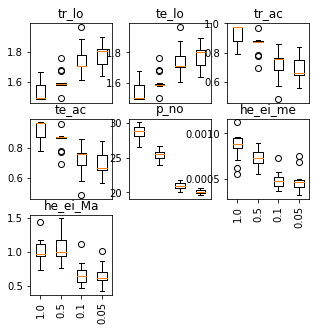

=== OPT frankwolfe_stochastic / METRIC train_loss ===
=== OPT frankwolfe_stochastic / METRIC test_loss ===
=== OPT frankwolfe_stochastic / METRIC train_acc ===
=== OPT frankwolfe_stochastic / METRIC test_acc ===
=== OPT frankwolfe_stochastic / METRIC p_norm ===
=== OPT frankwolfe_stochastic / METRIC hessian_eigens_mean ===
=== OPT frankwolfe_stochastic / METRIC hessian_eigens_Max ===


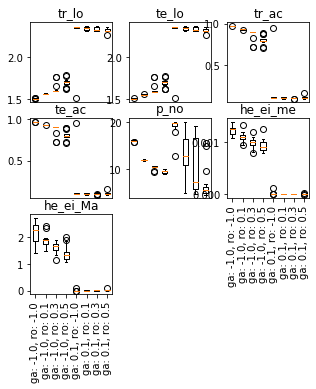

=== OPT frankwolfe_deterministic / METRIC train_loss ===
=== OPT frankwolfe_deterministic / METRIC test_loss ===
=== OPT frankwolfe_deterministic / METRIC train_acc ===
=== OPT frankwolfe_deterministic / METRIC test_acc ===
=== OPT frankwolfe_deterministic / METRIC p_norm ===
=== OPT frankwolfe_deterministic / METRIC hessian_eigens_mean ===
=== OPT frankwolfe_deterministic / METRIC hessian_eigens_Max ===


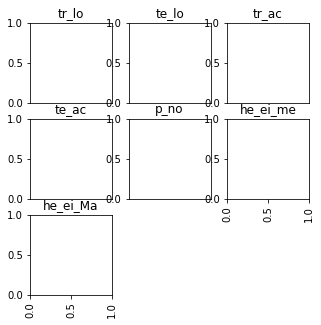

=== OPT adam / METRIC train_loss ===
=== OPT adam / METRIC test_loss ===
=== OPT adam / METRIC train_acc ===
=== OPT adam / METRIC test_acc ===
=== OPT adam / METRIC p_norm ===
=== OPT adam / METRIC hessian_eigens_mean ===
=== OPT adam / METRIC hessian_eigens_Max ===


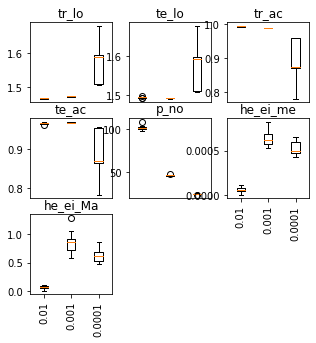

In [13]:
# printing all results (mean over runs/std)
for optim in param_groups.keys():
    data_for_metric = {}
    for m in all_metrics:
        print("=== OPT %s / METRIC %s ===" % (optim, m))
    
        # labels (parameters used)
        xs = []
        
        # values (arrays) for repetitions
        ys = []
    
        # going over parameters
        for p in param_groups[optim]:
            varying_params = dict_select(p, varying[optim])
            #print(varying_params)
            #print(dict_to_stat(param_to_result(p)))
            res = param_to_result(p, parameters, params_to_processed)
            if res is not None:
                ys.append(res[m])
                xs.append(shorten_dict(varying_params))
        data_for_metric[m] = (xs, ys)
        
    def plot_one(ax, i):
        """ Plot one box plot for metric i at axis ax """
        m = all_metrics[i] # current metric
        xs, ys = data_for_metric[m] # current data
        # plotting
        if xs:
            assert len(xs) == len(ys)
            ax.boxplot(ys, labels = xs)
    subplots(3, 3, all_metrics, plot_one, (5, 5))

### Batch size
Frank-Wolfe:batch size 1000-10K has almost no effect, a bit worse at 60K

Adam/SGD: Increase batch size -> decrease accuracy, increase loss. Hessian becomes a bit worse at 60K, but mostly decreases.

### Big

SGD: With decrease of learning rate, train/test accuracy decreases, loss increases, p-norm decreases and largest eigenvalues decrease. Choising LR=1

Frank-Wolfe Stochastic (g=-1). r = -1 gives best accuracy, constant rs are worse, the more the worse. p-norm decreases with accuracy, eigenvalues also decrease (max/mean). Constant gamma/rho give poor results

Frank-Wolfe deterministic: no data

Adam: with decrease of the learning rate, train accuracy decreases, sharp decrease for 0.0001. Hessian eigenvalues increase. Choosing LR = 0.001

In [14]:
# printing best parameters
for optim in param_groups.keys():
    idx = select_best(optim, parameters, param_groups, params_to_processed) # best hyperparameter idx
    p = parameters[idx] # best hyperparameters
    print(optim, dict_select(p, varying[optim]))

sgd {'learning_rate': 1.0}
frankwolfe_stochastic {'gamma': -1.0, 'ro': -1.0}
frankwolfe_deterministic {}
adam {'learning_rate': 0.001}


In [15]:
# final result for all optimizers (best)
data_for_optimizers = {}

# loop over metrics
for m in all_metrics:
    xs = [] # optimizers
    ys = [] # data for optimizers

    # print final results
    for optim in param_groups.keys():
        idx = select_best(optim, parameters, param_groups, params_to_processed) # best hyperparameter
        p = params_to_processed[idx]
        if p is not None:
            xs.append(shorten_name(optim))
            ys.append(p[m])
    
    # saving data...
    data_for_optimizers[m] = (xs, ys)

<Figure size 432x288 with 0 Axes>

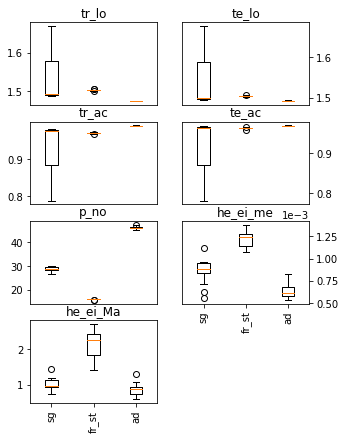

In [16]:
def plot_one(ax, i):
    """ Plot one box plot for metric i at axis ax """
    m = all_metrics[i] # current metric
    xs, ys = data_for_optimizers[m] # current data
    # plotting
    if xs:
        assert len(xs) == len(ys)
        ax.boxplot(ys, labels = xs)
    if i % 2 == 1:
        ax.yaxis.tick_right()
    if m == 'hessian_eigens_mean':
        #ax.yaxis.set_major_formatter(OOMFormatter(-4, "%1.1f"))
        ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
        pass
plt.subplots_adjust(wspace = 1)
subplots(4, 2, all_metrics, plot_one, (5, 7), 'best_' + setting_name)
plt.show()

### Batch size
Best accuracy: FW and Adam. Stochastic much better than deterministic for accuracy.

Hessian is a bit better for FW than for Adam

### Big

SGD: high variance, low Hessian

FW: high accuracy (a bit lower than Adam), low p-norm, high Hessian, hood generalization

Adam: highest accuracy, low variance, high p-norm, low Hessian, good generalization